#### **Density Profile Comparisons**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

In [1]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import scipy

sns.set(style = "ticks")
pi = np.pi

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

basePath = './TNG-100_3/outputs/'
basePath_dark = './TNG-100_3_Dark/outputs/'
snapshot_ind = 66

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)
halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_R_Mean200']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)
halo_grp['has_gas'] = True

header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)
halo_grp_fields_dark = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_R_Mean200']
halo_grp_dark = il.groupcat.loadHalos(basePath_dark, snapshot_ind, fields=halo_grp_fields_dark)
halo_grp_dark['has_gas'] = False

# Obtain basic cosmological info and obtain conversion factors
redshift = header['Redshift']
H = cosmo.H(redshift)
cosmo_col = colossus_cosmo.setCosmology('planck15');
conv_fac = 100/(H.value*1000) # Multiplicative factor to convert from kpc/h to Mpc
conv_fac_m = 1000*conv_fac # Multiplicative factor to convert mass units

# Define box boundary vector in Mpc (for period bcs)
boxsize = header['BoxSize'] # kpc/h
box_bounds = boxsize*conv_fac*np.ones(3)

# Get DM Particle mass
snap_dir_dark = './TNG-100_3_Dark/outputs/snapdir_066/snap_066.0.hdf5'

with h5py.File(snap_dir_dark) as f:
    snap_dark = dict( f['Header'].attrs.items() )
    
    
snap_dir_g = './TNG-100_3/outputs/snapdir_066/snap_066.0.hdf5'

with h5py.File(snap_dir_g) as f:
    snap_g = dict( f['Header'].attrs.items() )

dm_part_mass_dark = snap_dark['MassTable'][1]*10**10*conv_fac_m # Mass in solar mass
dm_part_mass = snap_g['MassTable'][1]*10**10*conv_fac_m

print("Snapshot Num: "+str(snapshot_ind))
print("Snapshot Boxsize: "+str(boxsize)+" [kpc/h]")
print("Snapshot Redshift: "+str(redshift))
print("Total Number of Halos in Snapshot: "+str(halo_grp['count']))

Snapshot Num: 66
Snapshot Boxsize: 75000.0 [kpc/h]
Snapshot Redshift: 0.524565820433923
Total Number of Halos in Snapshot: 138061


#### **Pick Subset of Halos to Analyze**:

Specify a subset of halos from TNG-100_3 and TNG-100_3_Dark catalogs to perform analysis on.

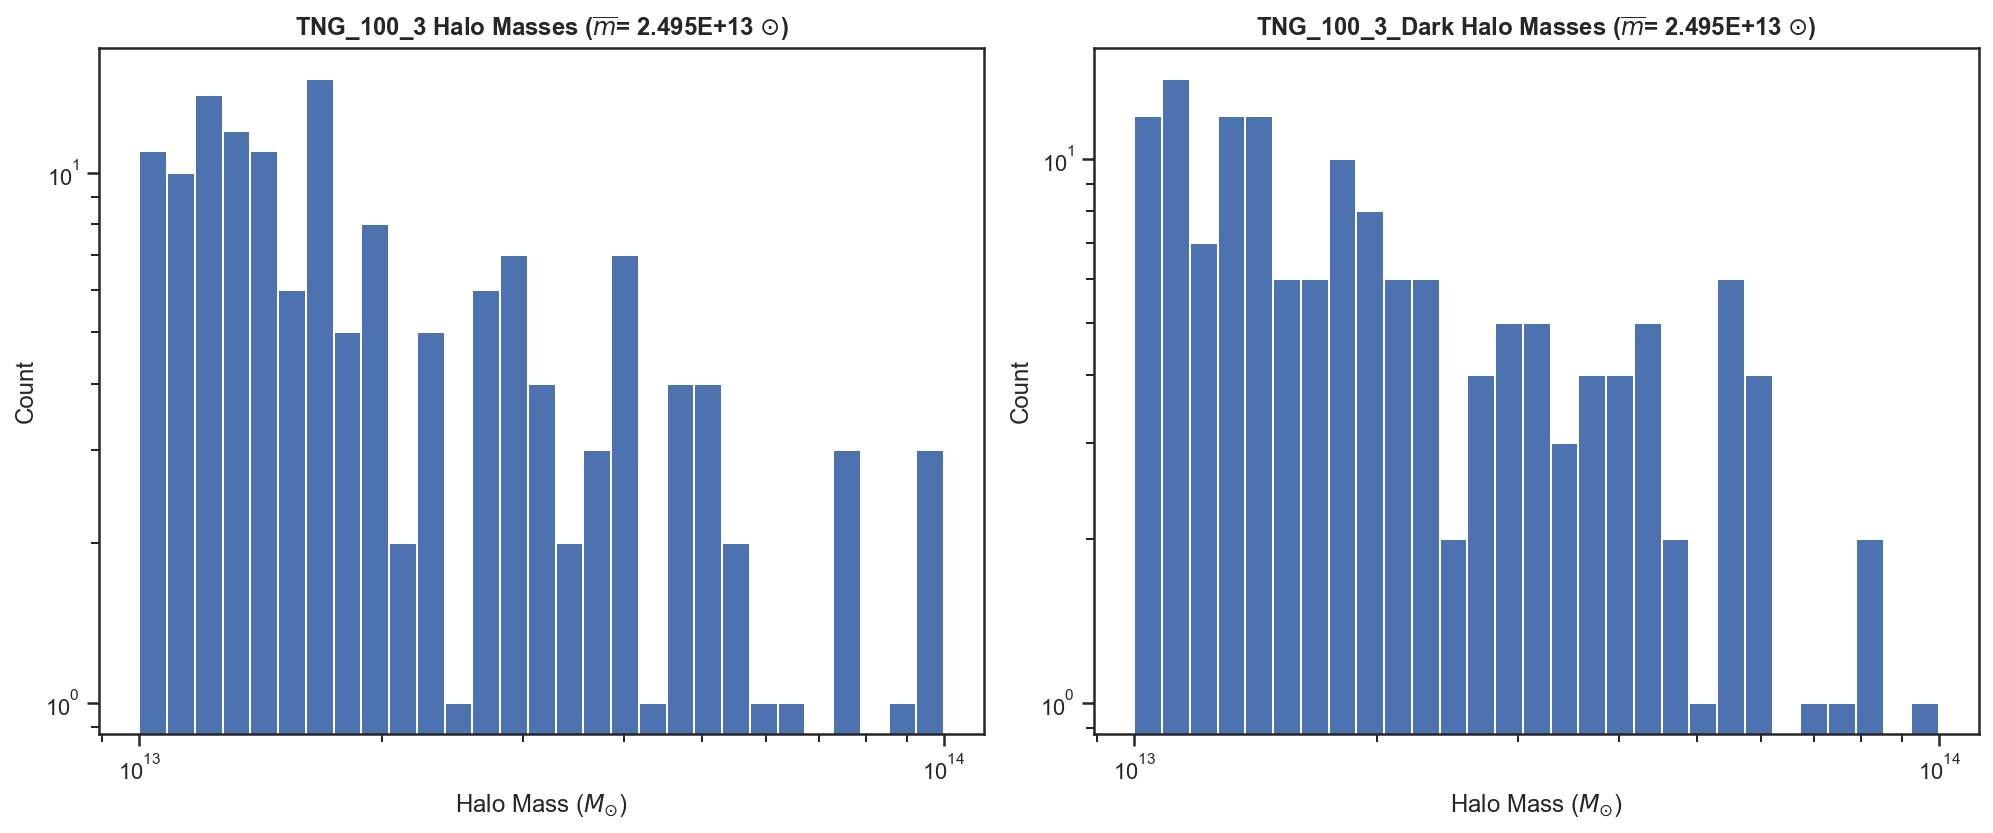

In [2]:
# Get all profiles with halo mass between 10^13-10^14 solar mass
halo_masses = halo_grp['GroupMass']*10**10*conv_fac_m
halo_masses_dark = halo_grp_dark['GroupMass']*10**10*conv_fac_m

halo_indices = np.where((halo_masses >= 10**13) & 
                        (halo_masses <= 10**14))[0]
halo_indices_dark = np.where((halo_masses_dark >= 10**13) & 
                             (halo_masses_dark <= 10**14))[0]

# Resample halo masses to balance the mean mass
m_bar_g = np.mean(halo_masses[halo_indices])

best_ind = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)

for i in range(10000):
    
    ind_dark = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)
    
    delta_best = np.abs(np.mean(halo_masses_dark[best_ind])-m_bar_g)
    delta_cur = np.abs(np.mean(halo_masses_dark[ind_dark])-m_bar_g)

    if delta_cur < delta_best:
        best_ind = ind_dark

halo_indices_dark = best_ind

# Plot selected halo mass distributions
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
bins = np.logspace(13, 14, 30)
plt.hist(halo_masses[halo_indices], bins=bins)
title_str = r"TNG_100_3 Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses[halo_indices]))
plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
bins = np.logspace(13, 14, 30)
plt.hist(halo_masses_dark[halo_indices_dark], bins=bins)
title_str = r"TNG_100_3_Dark Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses_dark[halo_indices_dark]))

plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

##### **Compute Halo Density Profile:**

Compute 2D and 3D denstiy profiles of the dark matter and gas within a halo.

In [3]:
BINS = np.logspace(-5, 1, 300) # Default bins for computing all halo profiles unless otherwise specified

class HALO_PROFILE(object):
   
    """
    Class for storing and computing density profiles of a particular halo 

    """
    
    def __init__(self, halo_grp, halo_ind, bins=BINS):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        halo_grp: dict
            The dictionary associated with the group catalog the halo is found in
            
        halo_ind: int
            The integer index of the halo within the halo_grp
            
        bins: float array
            Array containing the bin boundaries for computing the profiles
            
        """
        
        self._halo_grp = halo_grp
        self.halo_ind = halo_ind
        self.halo_cm = self._halo_grp['GroupCM'][self.halo_ind]*conv_fac
        self.halo_M_Crit200 = self._halo_grp['Group_M_Crit200'][self.halo_ind]*10**10*conv_fac_m
        self.has_gas = self._halo_grp['has_gas']
        self.halo_bins=bins
        
        # Load the associated halo and compute profiles
        if self.has_gas:
            # Load halos
            halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')
            halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind, 'gas')
            
            # Load gas/dm positions and masses
            self.halo_gas_pos = halo_gas['Coordinates']*conv_fac
            self.halo_dm_pos = halo_dm['Coordinates']*conv_fac
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][snapshot_ind]*conv_fac
            self.halo_gas_mass = halo_gas['Masses']*conv_fac_m*10**10

            # Compute 3D profiles
            self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                                 weights = dm_part_mass*np.ones(len(self.halo_dm_pos)))
            self.gas_3d_profile = self.compute_3D_density_profile(self.halo_gas_pos, weights=self.halo_gas_mass)
            
            total_pos = np.append(self.halo_dm_pos, self.halo_gas_pos, axis=0)
        
            dm_weights = dm_part_mass*np.ones(len(self.halo_dm_pos))
            total_weights = np.append(dm_weights, self.halo_gas_mass) 
            self.total_3d_profile = self.compute_3D_density_profile(total_pos, total_weights)
        
        
        else:
            # Load halo
            halo_dm = il.snapshot.loadHalo(basePath_dark, snapshot_ind, halo_ind,'dm')
            
            # Load dm positions
            self.halo_dm_pos = halo_dm['Coordinates']*conv_fac
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][snapshot_ind]*conv_fac
        
            # Compute 3D profiles
            self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                                 weights = dm_part_mass_dark*np.ones(len(self.halo_dm_pos)))
            self.total_3d_profile = self.dm_3d_profile
        
     
    def compute_3D_density_profile(self, positions, weights=None):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        positions: n*3 float array
             x, y, and z positions of particles
         
        Returns:
        -------
        average_bin_radius: float array 
            Average radial position of each density bin (Mpc)
            
        rho: array
            density of each radial bin (Counts/Mpc^3)
            
        """

        # Verify input has correct shape
        assert(len(positions.T==3))
        
        # Account for halos which go over the boundary
        dev = positions-self.halo_cm

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
    
        # Compute profile
        r = np.linalg.norm(dev, axis=1)            
        counts, r_edges = np.histogram(r, bins=self.halo_bins, weights=weights)
        
        dr = np.diff(r_edges)
        average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
        dV = 4*np.pi*average_bin_radius**2*dr

        rho = counts/dV

        return average_bin_radius, rho
    

def jackknife_var(halo_indices, averaged_r, averaged_rho, prof_key):

    """
    Compute averaged profiles for a set of halos within a halo group
    
    Parameters:
    ----------

    halo_indices: int array
        Array containing the integer indices of halos to be averaged
        
    averaged_r: float array
        Array containing the bins to average profiles
        
    averaged_rho: float array
        Array containing the bins to average profiles
    
    prof_key: string
        String indicating which profile to average (e.g. gas, dm, or total)

    Returns:
    -------
    averaged_r: array 
        Average radial position of each density bin (Mpc)

    averaged_rho: array
        density of each radial bin (Counts/Mpc^3)
            
    """
    
    possible_keys = ["gas", "dm", "tot"]
    
    assert(prof_key in possible_keys)
    
    # Estimate errors using jackknife 
    var_dm = np.zeros_like(averaged_r)
    n = len(halo_indices)
    val_ind_avg = np.where(averaged_rho != 0)[0]

    for i in halo_indices:

        halo_profile_i = HALO_PROFILE(halo_grp, i)
        
        # Compute correct profile
        if prof_key == "dm":
            rho_i = halo_profile_i.dm_3d_profile[1]
        
        elif prof_key == "gas":
            rho_i = halo_profile_i.gas_3d_profile[1]
            
        elif prof_key == "tot":
            rho_i = halo_profile_i.total_3d_profile[1]
            
        val_ind_i = np.where(rho_i != 0)[0]

        val_ind = np.intersect1d(val_ind_avg, val_ind_i)
        var_dm[val_ind] += (rho_i[val_ind]-averaged_rho[val_ind])**2
    
    return var_dm/(n*(n-1))
    

def compute_averaged_profiles(halo_grp, halo_indices, averaged_bins=BINS, prof_key="dm"):
    
    """
    Compute averaged profiles for a set of halos within a halo group
    
    Parameters:
    ----------
    halo_grp: dict
        The dictionary associated with the group catalog the halo is found in

    halo_indices: int array
        Array containing the integer indices of halos to be averaged
        
    averaged_bins: float array
        Array containing the bins to average profiles
    
    prof_key: string
        String indicating which profile to average (e.g. gas, dm, or total)

    Returns:
    -------
    averaged_r: array 
        Average radial position of each density bin (Mpc)

    averaged_rho: array
        density of each radial bin (Counts/Mpc^3)
        
    """
    
    possible_keys = ["gas", "dm", "tot"]
    
    assert(prof_key in possible_keys)
    
    halo_R_mean_200_total = 0

    r_full = np.array([], dtype = int)
    rho_full = np.array([], dtype = int)

    for halo_ind in halo_indices:

        assert((halo_ind >= 0).all() & (halo_ind < halo_grp['count']).all())

        # Load associated halo profile object
        halo_profile = HALO_PROFILE(halo_grp, halo_ind)
        
        # Compute correct profile
        if prof_key == "dm":
            r = halo_profile.dm_3d_profile[0]
            rho = halo_profile.dm_3d_profile[1]
        
        elif prof_key == "gas":
            r = halo_profile.gas_3d_profile[0]
            rho = halo_profile.gas_3d_profile[1]
            
        elif prof_key == "tot":
            r = halo_profile.total_3d_profile[0]
            rho = halo_profile.total_3d_profile[1]

        # Add results to array for averaging
        r_full = np.append(r_full, r/halo_profile.R_mean_200)
        rho_full = np.append(rho_full, rho)
        halo_R_mean_200_total += halo_profile.R_mean_200

    r_full *= halo_R_mean_200_total/len(halo_indices)

    # Compute average profile    
    averaged_rho, averaged_r, binnumbers = scipy.stats.binned_statistic(r_full, rho_full, 
                                                                        'mean', averaged_bins)
    averaged_r = averaged_r[:-1]
    
    var = jackknife_var(halo_indices, averaged_r, averaged_rho, prof_key)
    
    return averaged_r, averaged_rho, var

##### **Compute Average Profiles:**

Compute average profiles and estimate variance using jackknife.

In [4]:
# Compute averaged profile
averaged_r_dm, averaged_rho_dm, var_dm = compute_averaged_profiles(halo_grp, halo_indices, prof_key="dm")
averaged_r_gas, averaged_rho_gas, var_gas = compute_averaged_profiles(halo_grp, halo_indices, prof_key="gas")
averaged_r_tot, averaged_rho_tot, var_tot = compute_averaged_profiles(halo_grp, halo_indices, prof_key="tot")

averaged_r_tot_dark, averaged_rho_tot_dark, var_tot_dark = compute_averaged_profiles(halo_grp_dark, halo_indices_dark, prof_key="tot")

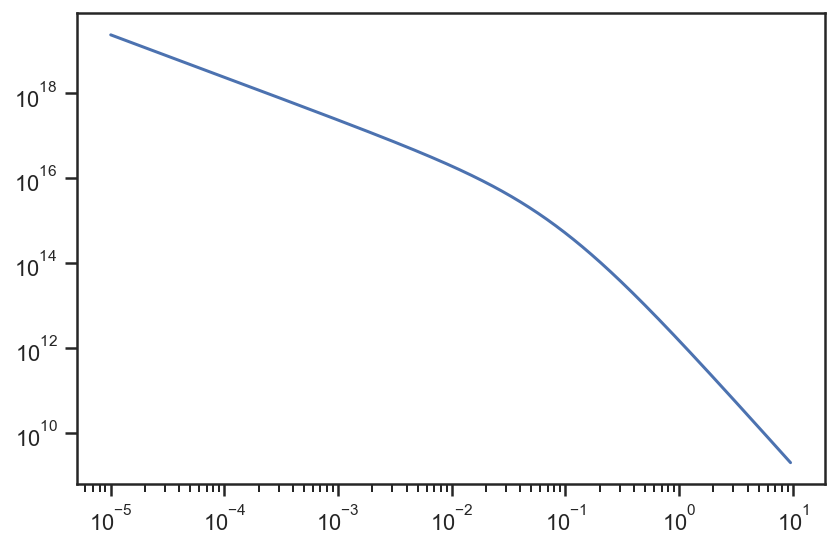

In [9]:
m_crit200_dark = np.mean(halo_grp_dark['Group_M_Crit200'][halo_indices_dark])
m_crit200 = np.mean(halo_grp['Group_M_Crit200'][halo_indices])

# Compute NFW Profile
cvir = concentration.concentration(m_crit200*10**10, mdef = '200c', z=redshift, model = 'bullock01')
p_nfw = profile_nfw.NFWProfile(M = m_crit200*10**10, 
                               c = cvir, z=redshift, mdef = '200c')

r_nfw = np.logspace(np.log10(np.min(averaged_r_dm)), 
                    np.log10(np.max(averaged_r_dm)), 1000)/conv_fac
rho_nfw = p_nfw.density(r_nfw) # density in units of M_sun h^2/kpc^3
rho_nfw *= 1000**3*(H.value/100)**2 # Convert to M_sun/Mpc^3

plt.plot(r_nfw*conv_fac, rho_nfw)
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

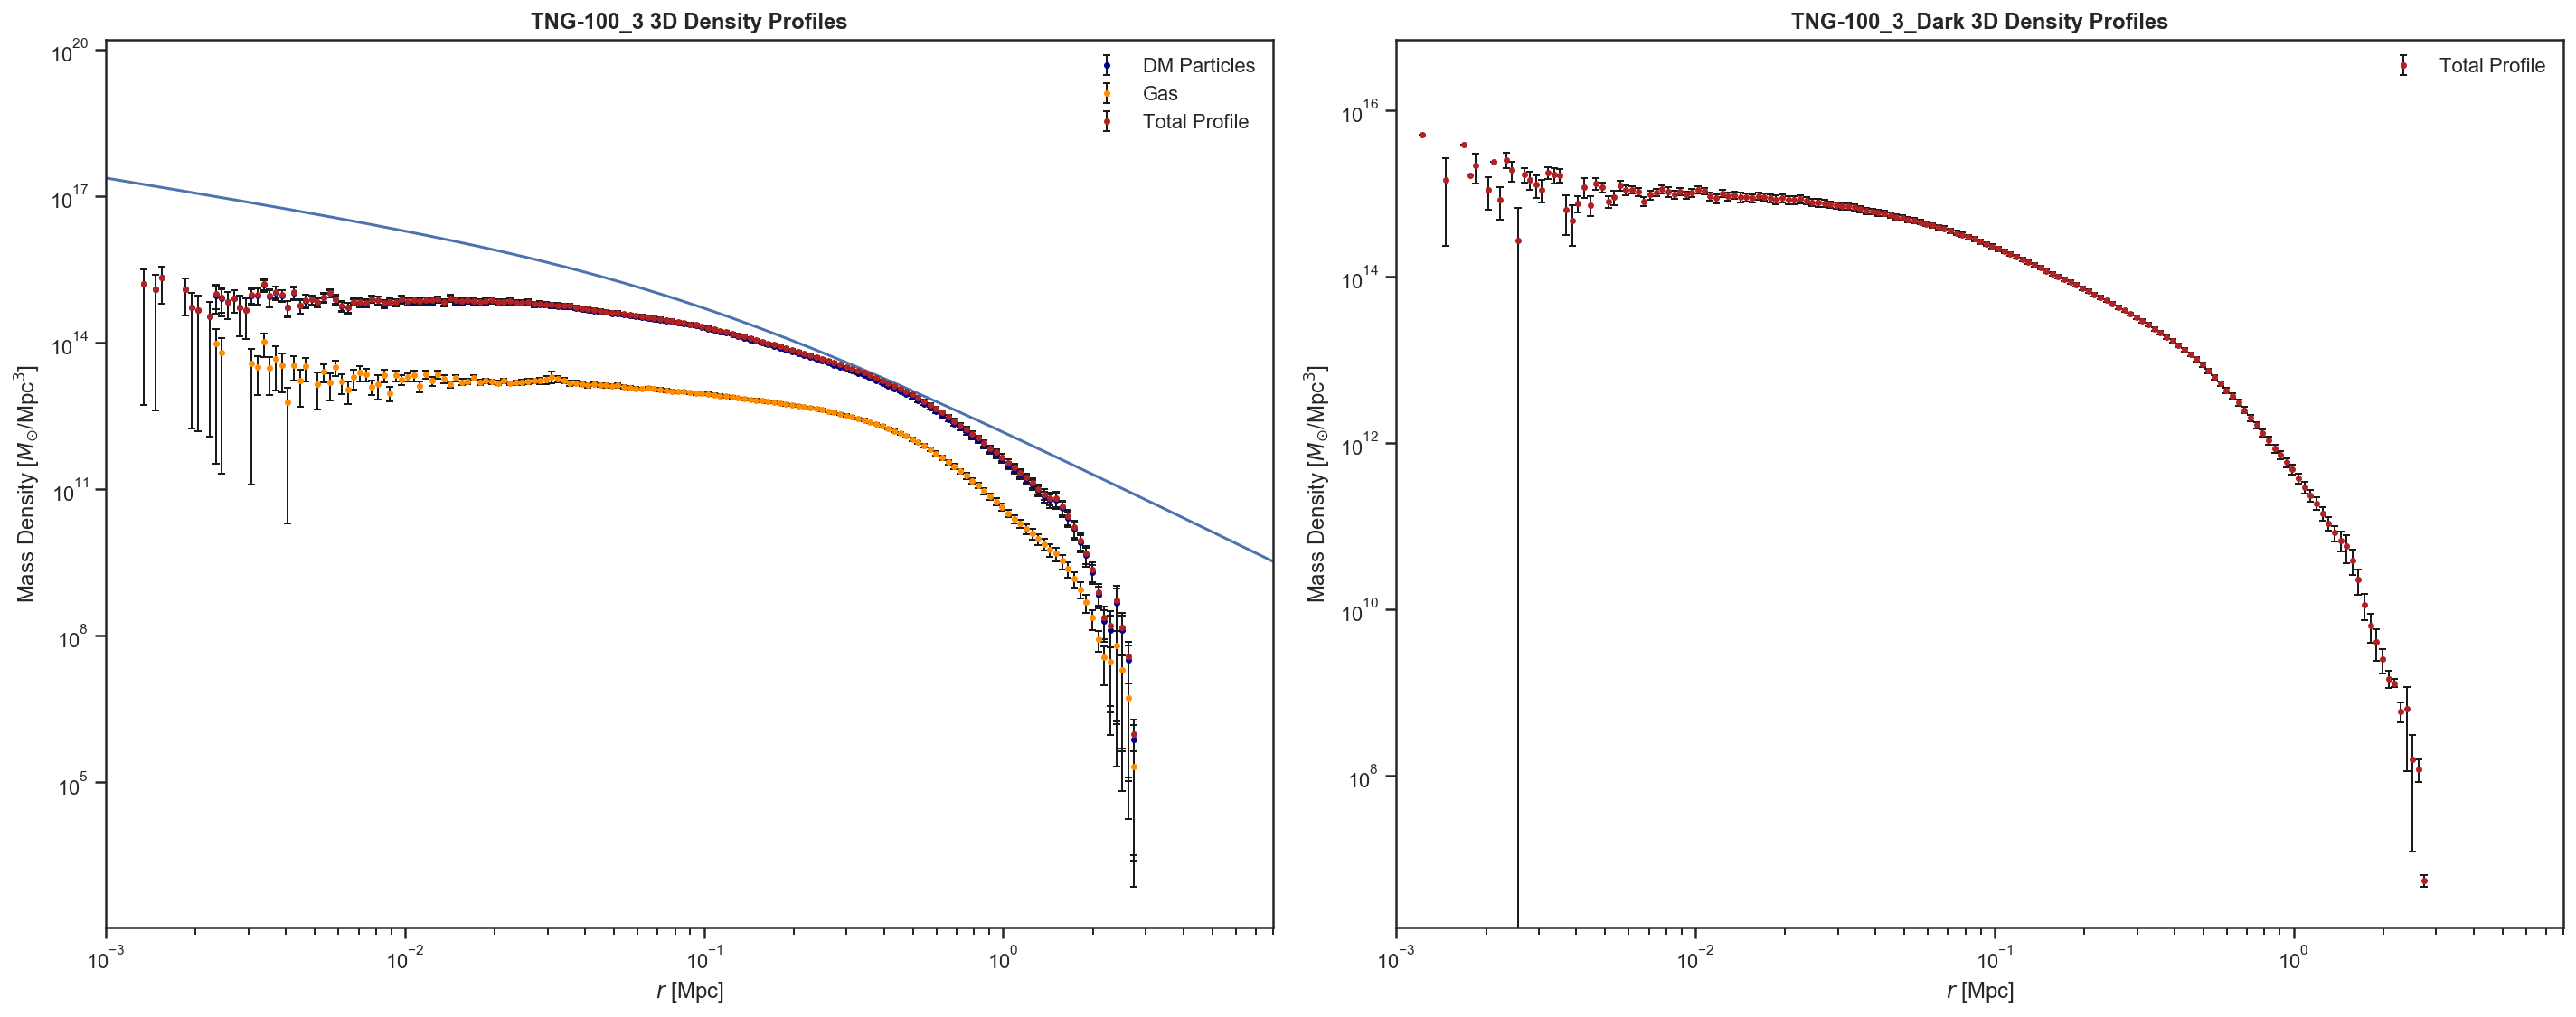

In [10]:
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.errorbar(averaged_r_dm, averaged_rho_dm, 
             yerr=np.sqrt(var_dm), 
             marker = '.', color = "darkblue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="DM Particles")

plt.errorbar(averaged_r_gas, averaged_rho_gas, 
             yerr=np.sqrt(var_gas), 
             marker = '.', color = "darkorange", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Gas")

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(var_tot), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")

plt.plot(r_nfw*conv_fac, rho_nfw)


plt.title("TNG-100_3 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel("Mass Density [$M_{\odot}$/Mpc$^3$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")
plt.xlim(10**-3, 8)


plt.subplot(1,2,2)

plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(var_tot_dark), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")

plt.title("TNG-100_3_Dark 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel("Mass Density [$M_{\odot}$/Mpc$^3$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")
plt.xlim(10**-3, 8)

plt.tight_layout()

##### **Compare Profiles**

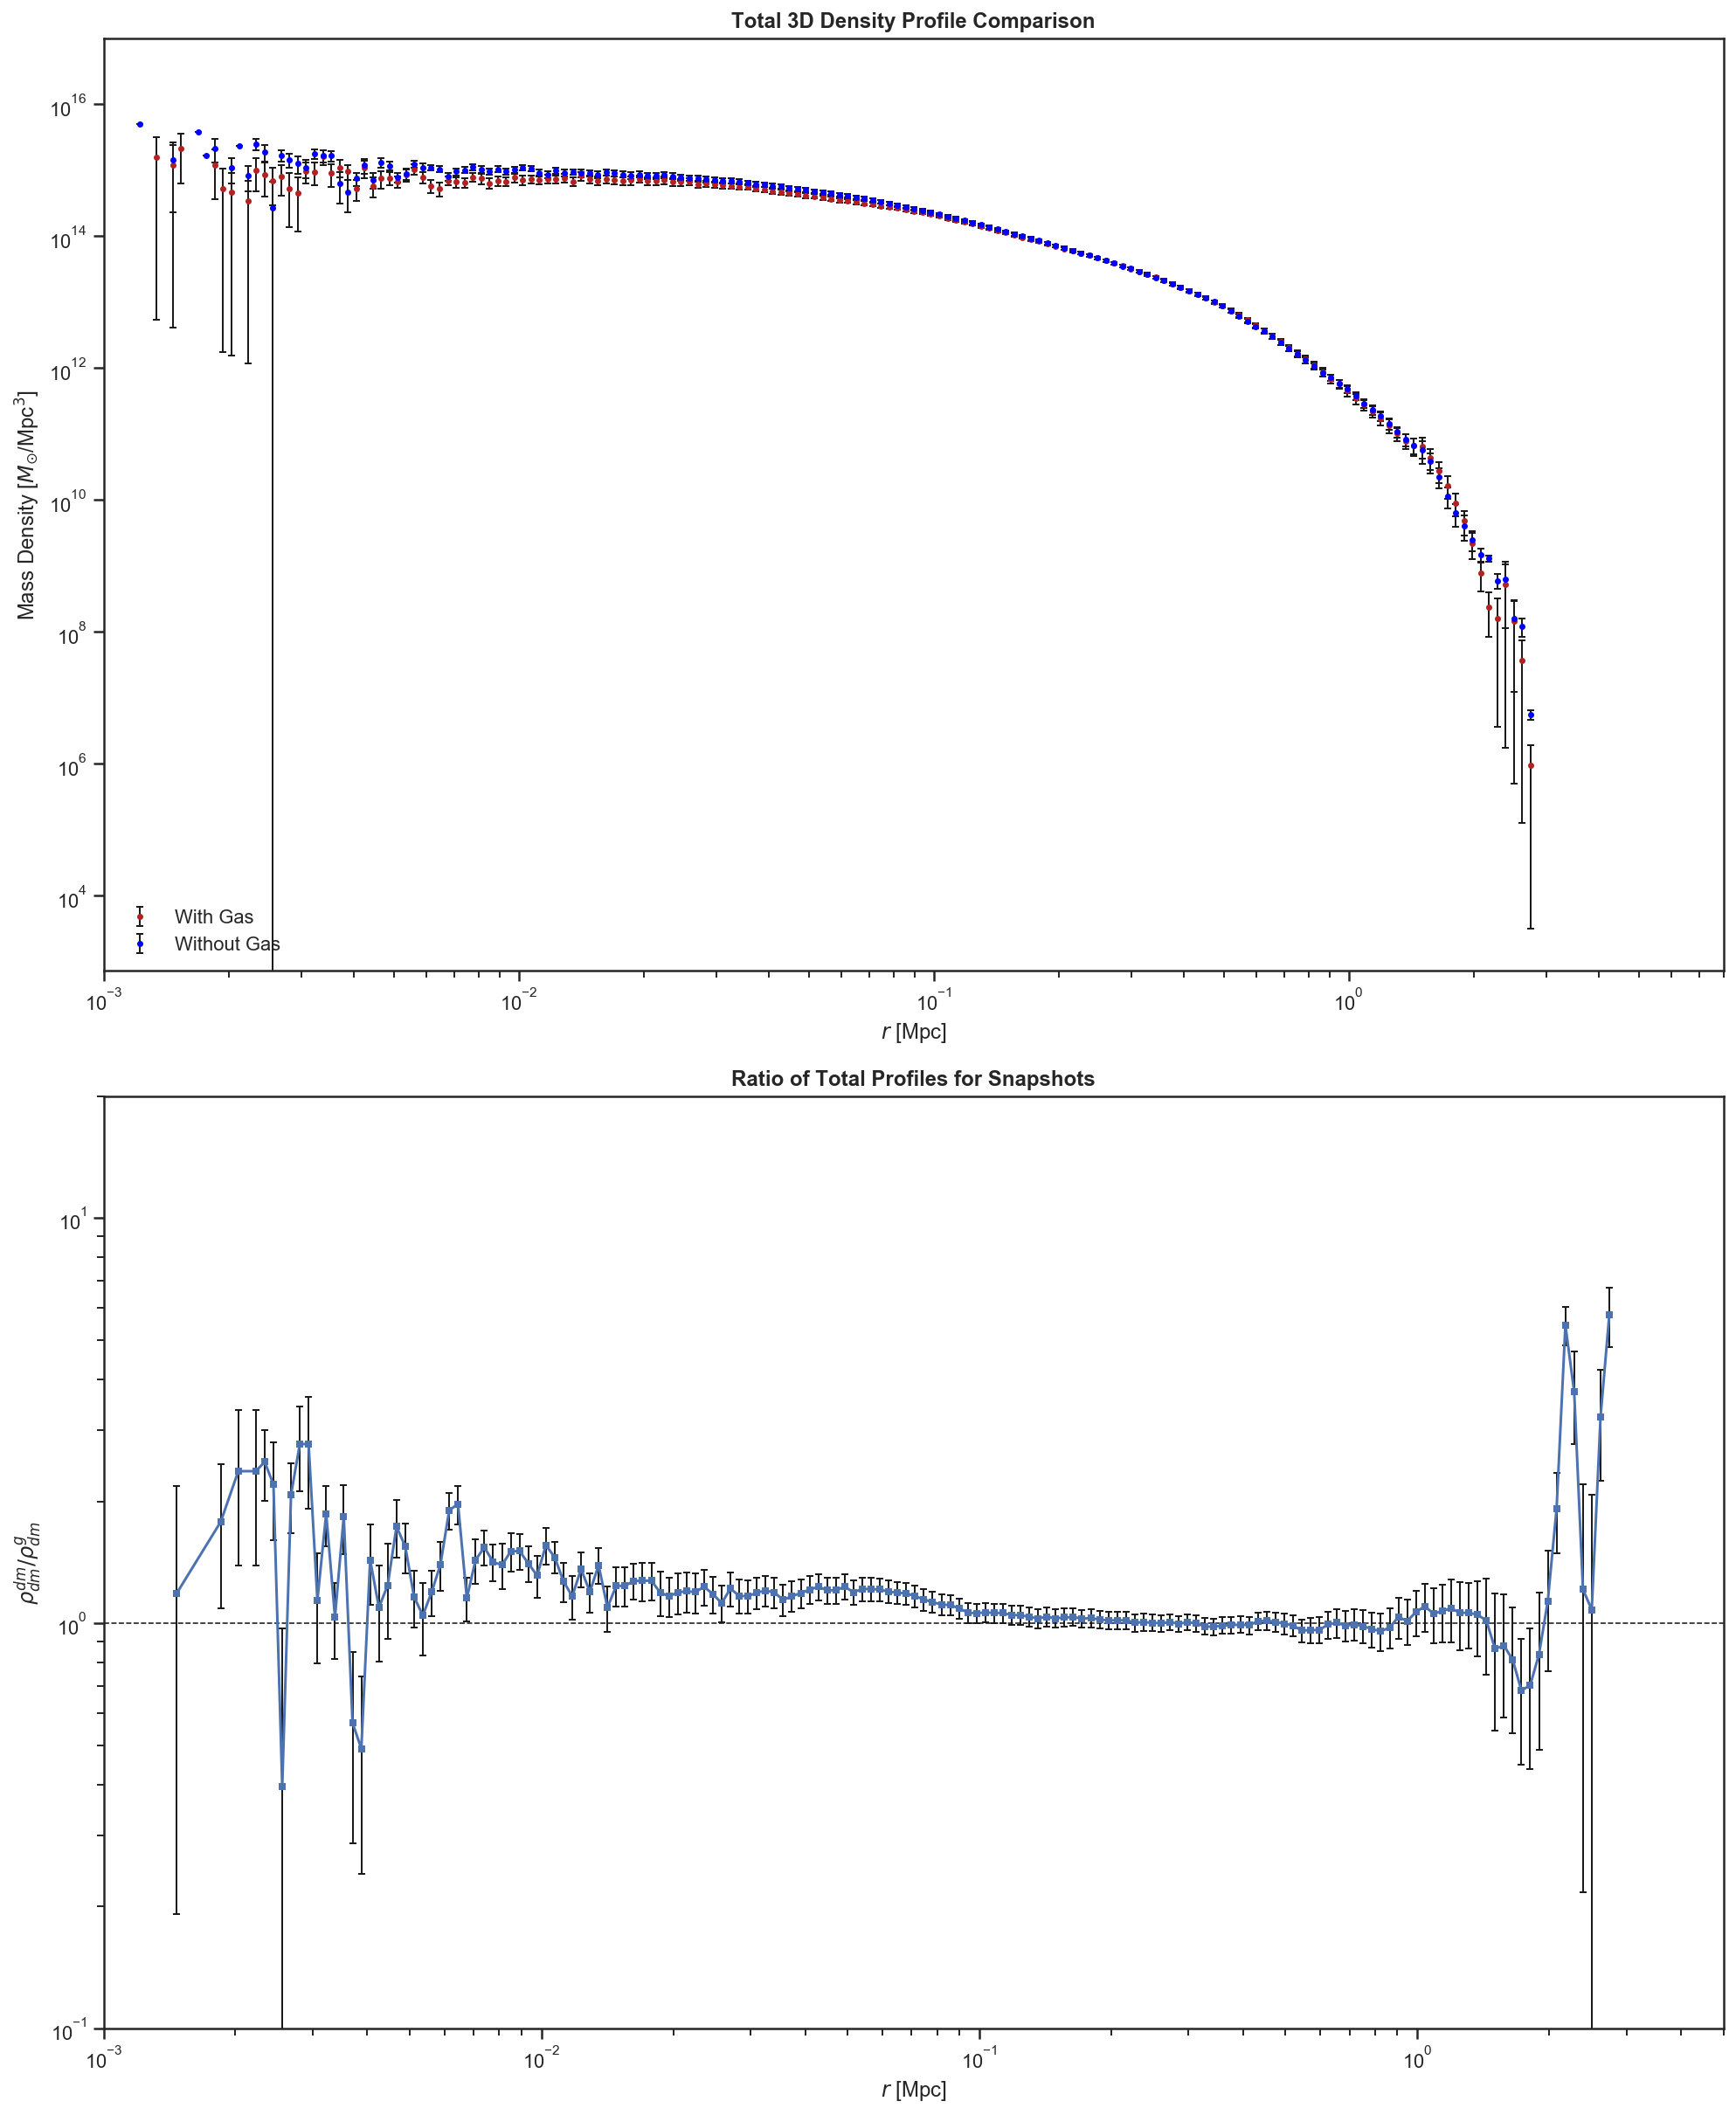

In [18]:
plt.figure(figsize=(14, 17))

plt.subplot(2,1,1)

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(var_tot), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="With Gas")


plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(var_tot_dark), 
             marker = '.', color = "blue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Without Gas")

plt.xlim(10**-3, 8)

plt.legend(frameon=False, loc="lower left")
plt.title("Total 3D Density Profile Comparison", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel("Mass Density [$M_{\odot}$/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")



plt.subplot(2,1,2)

ind_1 = np.where(averaged_rho_tot != 0)
ind_2 = np.where(averaged_rho_tot_dark != 0)
ind_inter = np.intersect1d(ind_1, ind_2)

delta_rho_1 = np.sqrt(np.sqrt(var_tot[ind_inter]))/averaged_rho_tot[ind_inter]
delta_rho_2 = np.sqrt(var_tot_dark[ind_inter])/averaged_rho_tot_dark[ind_inter]


frac_error = np.sqrt(delta_rho_1**2+delta_rho_2**2)

ratio_error = frac_error*(averaged_rho_tot_dark[ind_inter])/(averaged_rho_tot[ind_inter])
plt.axhline(1, color="k", linestyle="--", linewidth = 0.8)

plt.errorbar(averaged_r_tot[ind_inter],
             (averaged_rho_tot_dark[ind_inter])/(averaged_rho_tot[ind_inter]), 
             yerr=ratio_error, markersize = 3, ecolor = 'k', 
             elinewidth = 1, capsize=2, marker='s',
             markeredgewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.title("Ratio of Total Profiles for Snapshots", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\rho_{dm}^{dm} / \rho_{dm}^{g}$")
plt.xlim(10**-3, 5)
plt.ylim(10**-1, 20)

plt.tight_layout()